# 03. Self-Attention 직접 구현 (PyTorch)

## 학습 목표

-   Scaled Dot-Product Attention을 **처음부터 구현**
-   Q, K, V의 역할 이해
-   √d_k 스케일링이 필요한 이유 체험

## 관련 면접 질문

-   Self-Attention의 동작 원리를 설명해주세요
-   Q, K, V가 각각 무엇을 의미하나요?
-   √d_k로 나누는 이유는?
-   Attention mask는 언제 쓰나요?

## 핵심 수식

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$


---

## Pre-Quiz

### Q1. Self-Attention에서 Q, K, V의 역할은?

```
Q (Query):
K (Key):
V (Value):
```

### Q2. √d_k로 나누는 이유는?

```
당신의 답:
```

### Q3. Causal Mask는 언제 필요한가요?

```
당신의 답:
```


---

## Setup


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# 재현성
torch.manual_seed(42)

---

## 1. Scaled Dot-Product Attention 구현

### 구현 단계

1. Q와 K^T 내적 → attention scores
2. √d_k로 스케일링
3. (optional) mask 적용
4. softmax → attention weights
5. weights와 V 내적 → output

### Shape 흐름

```
Q: (batch, seq_q, d_k)
K: (batch, seq_k, d_k)
V: (batch, seq_k, d_v)

scores = Q @ K^T: (batch, seq_q, seq_k)
weights = softmax(scores): (batch, seq_q, seq_k)
output = weights @ V: (batch, seq_q, d_v)
```


In [44]:
# =================================================
# TODO: Scaled Dot-Product Attention 구현
# =================================================
#
# $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$
#
# Input shapes:
#   Q: (B, T, d_k)
#   K: (B, S, d_k)
#   V: (B, S, d_v)
#   mask: (B, T, S) - True인 위치는 attend 금지
#
# Output shapes:
#   output: (B, T, d_v)
#   weights: (B, T, S)
#
# 금지: F.scaled_dot_product_attention(), nn.MultiheadAttention()
#
# =================================================
import numpy as np


def scaled_dot_product_attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Scaled Dot-Product Attention"""

    scores = query @ key.transpose(-2, -1)
    d_k = query.size(-1)

    if mask is not None:
        scores = scores.masked_fill(mask, float("-inf"))

    attention_weight = F.softmax(scores / math.sqrt(d_k), dim=-1)
    output = attention_weight @ value

    return output, attention_weight

In [45]:
# ============ 테스트 1: 기본 동작 ============
def test_basic():
    batch, seq, d_k = 2, 4, 8
    q = torch.randn(batch, seq, d_k)
    k = torch.randn(batch, seq, d_k)
    v = torch.randn(batch, seq, d_k)

    output, weights = scaled_dot_product_attention(q, k, v)

    assert output.shape == (batch, seq, d_k), f"Output shape 오류: {output.shape}"
    assert weights.shape == (batch, seq, seq), f"Weights shape 오류: {weights.shape}"
    print("✅ 기본 동작 테스트 통과!")
    print(f"   Output shape: {output.shape}")
    print(f"   Weights shape: {weights.shape}")


test_basic()

✅ 기본 동작 테스트 통과!
   Output shape: torch.Size([2, 4, 8])
   Weights shape: torch.Size([2, 4, 4])


In [46]:
# ============ 테스트 2: Softmax 검증 ============
def test_softmax():
    batch, seq, d_k = 2, 4, 8
    q = torch.randn(batch, seq, d_k)
    k = torch.randn(batch, seq, d_k)
    v = torch.randn(batch, seq, d_k)

    _, weights = scaled_dot_product_attention(q, k, v)

    # 각 row의 합이 1인지 확인
    row_sums = weights.sum(dim=-1)
    assert torch.allclose(row_sums, torch.ones_like(row_sums), atol=1e-5), f"Weights 합이 1이 아님: {row_sums}"
    print("✅ Softmax 검증 통과! (각 row 합 = 1)")


test_softmax()

✅ Softmax 검증 통과! (각 row 합 = 1)


In [47]:
# ============ 테스트 3: Mask 적용 ============
def test_mask():
    batch, seq, d_k = 2, 4, 8
    q = torch.randn(batch, seq, d_k)
    k = torch.randn(batch, seq, d_k)
    v = torch.randn(batch, seq, d_k)

    # Causal mask (상삼각 = True)
    mask = torch.triu(torch.ones(seq, seq), diagonal=1).bool()
    mask = mask.unsqueeze(0).expand(batch, -1, -1)

    _, weights = scaled_dot_product_attention(q, k, v, mask=mask)

    # 마스크된 위치의 weight는 0이어야 함
    masked_weights = weights[mask]
    assert torch.allclose(
        masked_weights, torch.zeros_like(masked_weights), atol=1e-6
    ), f"마스크된 위치가 0이 아님: max={masked_weights.max()}"
    print("✅ Mask 적용 테스트 통과!")
    print(f"   마스크된 위치 max weight: {masked_weights.max():.2e}")


test_mask()

✅ Mask 적용 테스트 통과!
   마스크된 위치 max weight: 0.00e+00


In [48]:
# ============ 테스트 4: PyTorch 구현과 비교 ============
def test_vs_pytorch():
    batch, seq, d_k = 2, 4, 8
    q = torch.randn(batch, seq, d_k)
    k = torch.randn(batch, seq, d_k)
    v = torch.randn(batch, seq, d_k)

    our_output, _ = scaled_dot_product_attention(q, k, v)
    pytorch_output = F.scaled_dot_product_attention(q, k, v)

    assert torch.allclose(our_output, pytorch_output, atol=1e-5), f"PyTorch 구현과 다름!"
    print("✅ PyTorch 공식 구현과 동일! 🎉")


test_vs_pytorch()

✅ PyTorch 공식 구현과 동일! 🎉


---

## 2. SelfAttention 클래스 구현

입력 X를 Q, K, V로 projection한 후 attention 계산

```
X: (batch, seq, d_model)
    ↓ W_q, W_k, W_v (Linear layers)
Q, K, V: (batch, seq, d_k), (batch, seq, d_k), (batch, seq, d_v)
    ↓ scaled_dot_product_attention
Output: (batch, seq, d_v)
```


In [49]:
# =================================================
# TODO: SelfAttention 클래스 구현
# =================================================
#
# Self-Attention: 같은 입력 X에서 Q, K, V를 만듦
#
# $$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$$
#
# X: (B, T, d_model) → Output: (B, T, d_v)
#
# =================================================


class SelfAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int = None, d_v: int = None):
        """
        Args:
            d_model: 입력 차원
            d_k: Q, K 차원 (default: d_model)
            d_v: V 차원 (default: d_model)
        """
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k if d_k else d_model
        self.d_v = d_v if d_v else d_model # 대부분 d_k == d_v 이나, 개념적으로 구분

        self.WQ = nn.Linear(d_model, self.d_k)
        self.WK = nn.Linear(d_model, self.d_k)
        self.WV = nn.Linear(d_model, self.d_v)  # weight는 선언 시, 랜덤 초기화
        # weight는 pytorch 기준, 내부적으로 이렇게 초기화됨 (Kaiming Uniform)
        # bound = 1 / math.sqrt(in_features)  # 1 / sqrt(512) ≈ 0.044

        # weight: Uniform(-bound, +bound)  # 약 -0.044 ~ +0.044 사이 균등 분포
        # bias:   Uniform(-bound, +bound)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (B, T, d_model)
        Returns:
            output: (B, T, d_v)
            weights: (B, T, T)
        """
        # ============================================
        # Q, K, V 생성 후 attention 계산
        Q = self.WQ(x)
        K = self.WK(x)
        V = self.WV(x)

        output, weight = scaled_dot_product_attention(Q, K, V, mask)
        return output, weight

In [50]:
# ============ 테스트: SelfAttention ============
def test_self_attention():
    batch, seq, d_model = 2, 4, 64
    x = torch.randn(batch, seq, d_model)

    attention = SelfAttention(d_model)
    output, weights = attention(x)

    assert output.shape == x.shape, f"Output shape 오류: {output.shape}"
    assert weights.shape == (batch, seq, seq), f"Weights shape 오류: {weights.shape}"

    # d_k, d_v 다르게 설정
    attention2 = SelfAttention(d_model, d_k=32, d_v=48)
    output2, _ = attention2(x)
    assert output2.shape == (batch, seq, 48), f"d_v 적용 오류: {output2.shape}"

    print("✅ SelfAttention 테스트 통과!")
    print(f"   Input: {x.shape} → Output: {output.shape}")


test_self_attention()

✅ SelfAttention 테스트 통과!
   Input: torch.Size([2, 4, 64]) → Output: torch.Size([2, 4, 64])


---

## 3. Attention 시각화

학습된 attention weights를 heatmap으로 시각화합니다.


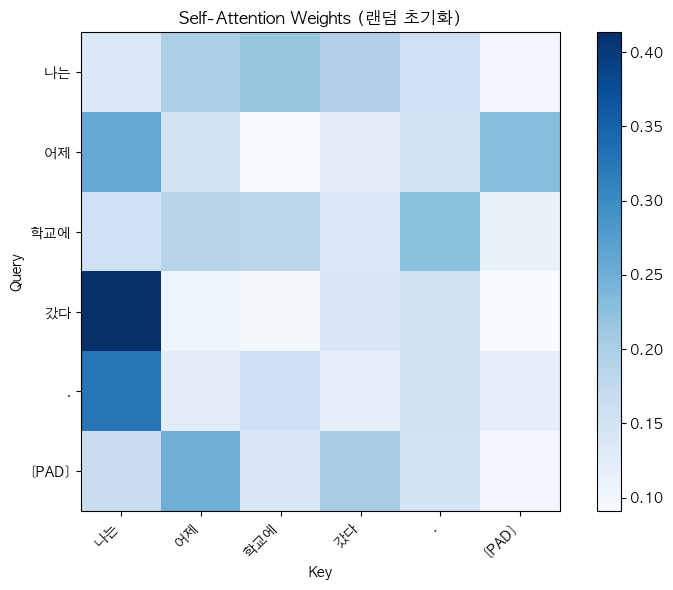

In [51]:
def visualize_attention(weights, tokens=None, title="Attention Weights"):
    """Attention weights heatmap 시각화"""
    if weights.dim() == 3:
        weights = weights[0]  # 첫 번째 배치만

    weights = weights.detach().numpy()
    seq_len = weights.shape[0]

    if tokens is None:
        tokens = [f"pos_{i}" for i in range(seq_len)]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(weights, cmap="Blues")

    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.set_yticklabels(tokens)

    ax.set_xlabel("Key")
    ax.set_ylabel("Query")
    ax.set_title(title)

    plt.colorbar(im)
    plt.tight_layout()
    plt.show()


# 예시
batch, seq, d_model = 1, 6, 64
x = torch.randn(batch, seq, d_model)
attention = SelfAttention(d_model)
_, weights = attention(x)

tokens = ["나는", "어제", "학교에", "갔다", ".", "[PAD]"]
visualize_attention(weights, tokens, "Self-Attention Weights (랜덤 초기화)")

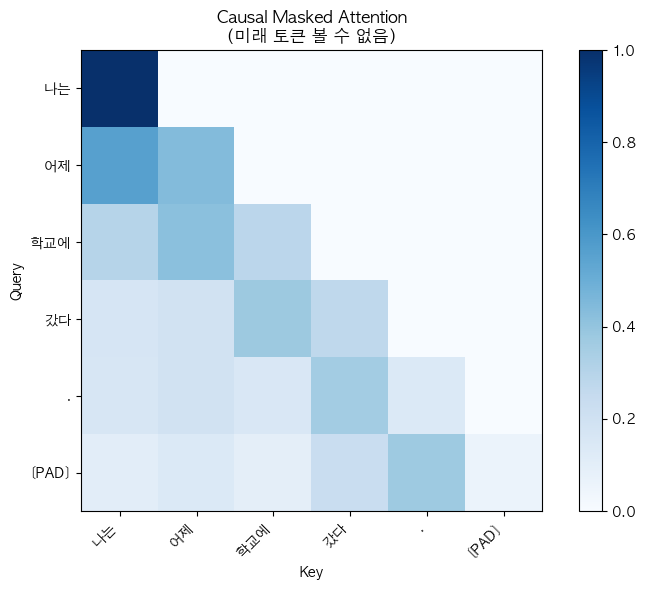

In [52]:
# Causal Mask 적용 시각화
seq = 6
causal_mask = torch.triu(torch.ones(seq, seq), diagonal=1).bool()

x = torch.randn(1, seq, d_model)
_, weights_causal = attention(x, mask=causal_mask)

visualize_attention(weights_causal, tokens, "Causal Masked Attention\n(미래 토큰 볼 수 없음)")

---

## 4. √d_k 스케일링 효과 실험

스케일링 없이 어떤 문제가 생기는지 확인합니다.


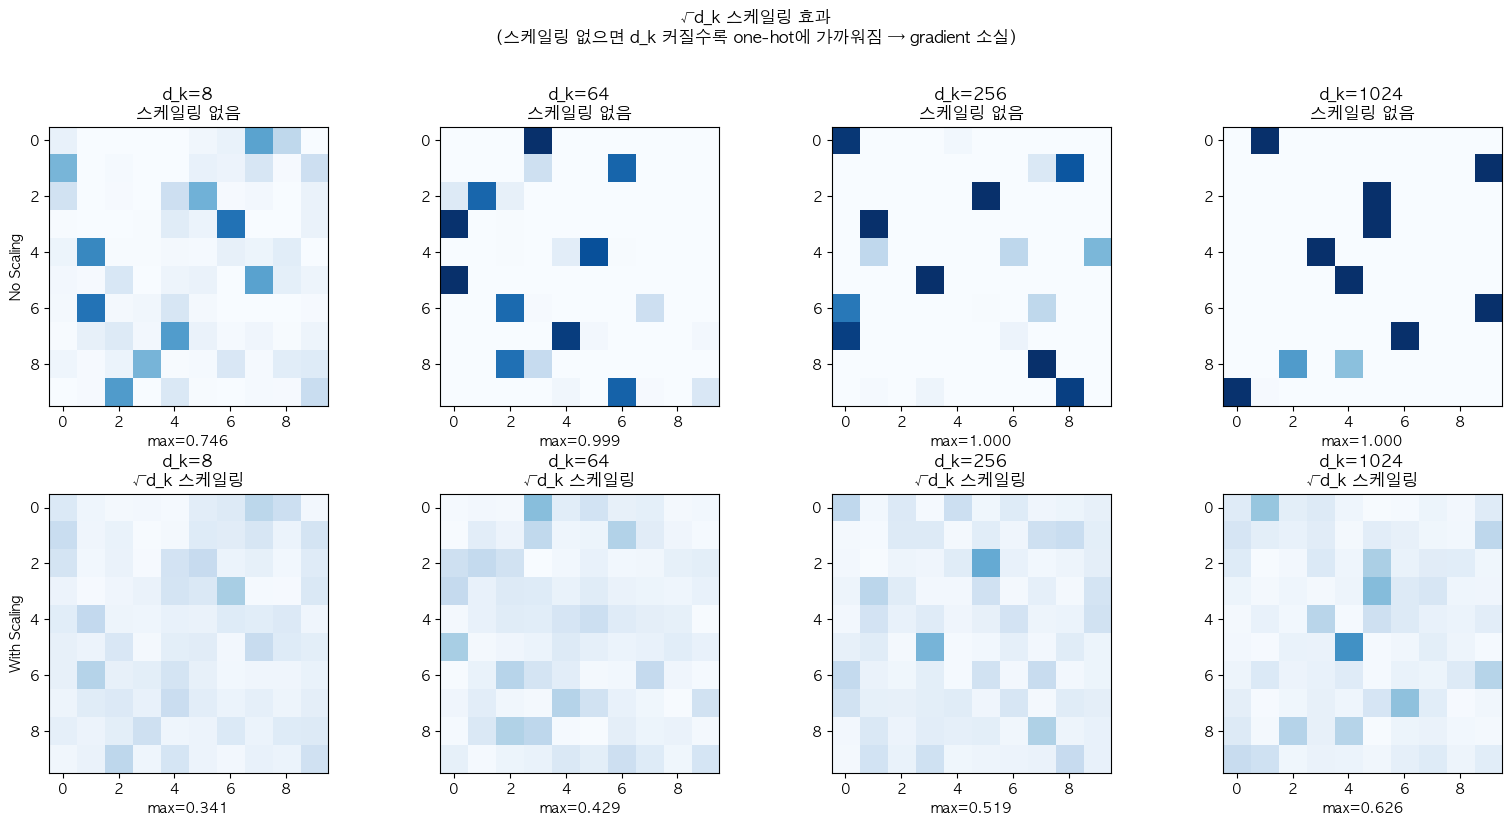

In [53]:
def attention_without_scaling(query, key, value):
    """스케일링 없는 attention (문제 확인용)"""
    scores = torch.bmm(query, key.transpose(-2, -1))
    # √d_k로 나누지 않음!
    weights = F.softmax(scores, dim=-1)
    output = torch.bmm(weights, value)
    return output, weights


# d_k가 커질수록 문제 심화
d_k_values = [8, 64, 256, 1024]

fig, axes = plt.subplots(2, len(d_k_values), figsize=(16, 8))

for i, d_k in enumerate(d_k_values):
    q = torch.randn(1, 10, d_k)
    k = torch.randn(1, 10, d_k)
    v = torch.randn(1, 10, d_k)

    # 스케일링 없음
    _, weights_no_scale = attention_without_scaling(q, k, v)

    # 스케일링 있음
    _, weights_scaled = scaled_dot_product_attention(q, k, v)

    # 시각화
    axes[0, i].imshow(weights_no_scale[0].detach(), cmap="Blues", vmin=0, vmax=1)
    axes[0, i].set_title(f"d_k={d_k}\n스케일링 없음")
    axes[0, i].set_xlabel(f"max={weights_no_scale.max():.3f}")

    axes[1, i].imshow(weights_scaled[0].detach(), cmap="Blues", vmin=0, vmax=1)
    axes[1, i].set_title(f"d_k={d_k}\n√d_k 스케일링")
    axes[1, i].set_xlabel(f"max={weights_scaled.max():.3f}")

axes[0, 0].set_ylabel("No Scaling")
axes[1, 0].set_ylabel("With Scaling")

plt.suptitle("√d_k 스케일링 효과\n(스케일링 없으면 d_k 커질수록 one-hot에 가까워짐 → gradient 소실)", y=1.02)
plt.tight_layout()
plt.show()

---

## Post-Quiz

### Q1. 스케일링 없이 d_k가 커지면 attention weights가 어떻게 변하나요?

```
당신의 답:
```

### Q2. 이것이 학습에 왜 문제가 되나요?

```
당신의 답:
```

### Q3. Causal mask를 적용하면 attention 패턴이 어떻게 바뀌나요?

```
당신의 답:
```


---
## 정답 및 해설

<details>
<summary>👉 클릭하여 정답 보기</summary>

### Pre-Quiz 정답

**Q1. Q, K, V의 역할**
> - Q (Query): "무엇을 찾고 있는지" - 현재 위치에서 어떤 정보가 필요한지
> - K (Key): "무엇을 가지고 있는지" - 각 위치가 어떤 정보를 제공하는지
> - V (Value): "실제 값" - 실제로 전달할 정보
> - Q·K 내적 = 유사도, 높으면 해당 V를 많이 가져옴

**Q2. √d_k로 나누는 이유**
> - d_k가 크면 Q·K 내적값의 분산이 커짐 (각 원소가 독립이면 분산 ∝ d_k)
> - 내적값이 크면 softmax가 극단적 (one-hot에 가까움)
> - gradient가 거의 0 → 학습 불가
> - √d_k로 나누면 분산을 1로 정규화

**Q3. Causal Mask**
> - Decoder에서 사용 (GPT 등)
> - 미래 토큰을 볼 수 없게 함 (Auto-regressive 생성)
> - 상삼각 부분을 -inf로 마스킹

---

### Post-Quiz 정답

**Q1. 스케일링 없이 d_k 커지면?**

> -   내적값 분산 증가 → softmax 입력이 극단적
> -   attention weights가 one-hot에 가까워짐
> -   하나의 토큰에만 거의 100% 집중

**Q2. 학습에 왜 문제?**

> -   softmax(극단값)의 gradient ≈ 0
> -   Vanishing Gradient → 학습 안 됨
> -   여러 토큰의 정보를 혼합하지 못함

**Q3. Causal mask 패턴**

> -   하삼각 패턴 (대각선 포함)
> -   각 위치는 자신과 이전 위치만 볼 수 있음
> -   첫 토큰은 자기 자신만, 마지막 토큰은 모든 이전 토큰 참조

</details>


---

## 구현 정답 코드

<details>
<summary>👉 클릭하여 정답 코드 보기</summary>

```python
def scaled_dot_product_attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
) -> tuple[torch.Tensor, torch.Tensor]:

    d_k = query.size(-1)

    # 1. Q @ K^T
    scores = torch.bmm(query, key.transpose(-2, -1))

    # 2. Scale by √d_k
    scores = scores / math.sqrt(d_k)

    # 3. Apply mask
    if mask is not None:
        scores = scores.masked_fill(mask, float('-inf'))

    # 4. Softmax
    weights = F.softmax(scores, dim=-1)

    # 5. Weighted sum with V
    output = torch.bmm(weights, value)

    return output, weights


class SelfAttention(nn.Module):
    def __init__(self, d_model: int, d_k: int = None, d_v: int = None):
        super().__init__()

        self.d_k = d_k if d_k is not None else d_model
        self.d_v = d_v if d_v is not None else d_model

        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_v)

    def forward(
        self, x: torch.Tensor, mask: Optional[torch.Tensor] = None
    ) -> tuple[torch.Tensor, torch.Tensor]:

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        output, weights = scaled_dot_product_attention(Q, K, V, mask)

        return output, weights
```

</details>
